In [1]:
!pip install numpy
!pip install matplotlib
!pip install scikit-image
!pip install pillow
!pip install opencv-python
!pip install timm
!pip install tqdm
# Check is at least python 3.9
import sys 
assert (sys.version_info.major == 3) and (sys.version_info.minor == 9)

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from PIL import Image
from typing import Callable
import os
from datetime import datetime
from enum import Enum
import random
from skimage.color import rgb2gray, rgb2hsv
from skimage import filters
from skimage import segmentation
from skimage.morphology import remove_small_holes, remove_small_objects
import cv2 as cv


In [3]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import timm
import torchvision
from torchvision.models.vision_transformer import vit_b_16
from torchvision.models import ViT_B_16_Weights

c:\Users\iab_b\miniconda3\envs\iapr_project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import platform

# Get os name
os_name = platform.system().lower()
num_workers = 8

# OS X
if 'darwin' in os_name:
    print("Detected OS X")
    %pip install torch==1.8.1 torchvision==0.9.1 torchaudio==0.8.1
# Linux 
elif 'linux' in os_name:
    print("Detected Linux")
    %pip install torch==1.8.1 torchvision==0.9.1 -f https://download.pytorch.org/whl/torch_stable.html
# Windows 
else:
    print("Detected Windows")
    num_workers = 0  # Hard fix for Windows users
    %pip install torch==1.12.0 torchvision==0.13 -f https://download.pytorch.org/whl/torch_stable.html


Detected Windows
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Note: you may need to restart the kernel to use updated packages.


In [5]:
class ImageType(Enum):
    NEUTRAL = "1. neutral_bg"
    NOISY = "2. noisy_bg"
    HAND = "3. hand"
    NEUTRAL_OOD = "4. neutral_bg_outliers"
    NOISY_OOD = "5. noisy_bg_outliers"
    HAND_OOD = "6. hand_outliers"
    
def loadImageOfType(type: ImageType, downsample: int = 1, grayscale: bool = False):
    # directory = f"./data/train/{type}"
    directory = os.path.join(".", "data", "train", type.value)
    images = os.listdir(directory)
    img = np.array(Image.open(os.path.join(directory, random.choice(images)))) 
    if downsample > 1:
        img = img[::downsample, ::downsample, :]
    if grayscale:
        img = (rgb2gray(img)*255).astype(np.uint8)
        
    # img = filters.sobel(img)
    
    return img
        


## Preprocessing

In [6]:
def filter_circles(circle_array):
    # print(circle_array)
    # Convert the array to a NumPy array
    
    # Find unique center coordinates
    unique_centers, unique_indices = np.unique(circle_array[:, :2], axis=0, return_index=True)
    # print(unique_indices)
    
    # Get the indices of circles with largest radius for each unique center
    largest_circles = []
    for center in unique_centers:
      largest_circle = np.array((center[0], center[1], 0))
      for j in range(len(circle_array)):
        circle = circle_array[j]
        if (circle[0] == center[0] and circle[1]==center[1] and circle[2] > largest_circle[2]):
          largest_circle[2] = circle[2] 
      largest_circles.append(largest_circle)
  
    # print(largest_circles)
               
      

    # # Convert the list of indices to a NumPy array
    # max_radius_indices = np.array(max_radius_indices)
    # print(max_radius_indices)
    
    return np.array(largest_circles)

In [7]:
# the input is a cv image so x and y are swapped
def extract_circles_images(x, y, r, img, down):
    factor = r + 10
    left = (x - factor)*down
    right = (x + factor)*down
    up = (y - factor)*down
    bottom = (y + factor)*down
    output = img.copy()
    output[:, :, 0] = img[:, :, 2]
    output[:, :, 2] = img[:, :, 0]
    return output[up:bottom, left:right, :]

In [8]:
def find_circles(path, debug = False):
    img = cv.imread(path)
    full_size_img = img.copy()
    down = 3
    size = (int(img.shape[1]/down), int(img.shape[0]/down))
    img = cv.resize(img, size, interpolation=cv.INTER_LINEAR)

    output = img.copy()
    output[:, :, 0] = img[:, :, 2]
    output[:, :, 2] = img[:, :, 0]
    img[:, :, 2] = 0


	# canny = cv.Canny(gray, 100, 200)
	# plt.imshow(canny, cmap="gray")
	# plt.show()


    gray = cv.blur(cv.cvtColor(img, cv.COLOR_BGR2GRAY), (8, 8))

    # detect circles in the image
    circles = cv.HoughCircles(gray, cv.HOUGH_GRADIENT_ALT, dp=1, minDist = 50, minRadius=50, maxRadius=200, param1=5, param2=0.6)
    # ensure at least some circles were found
    circles_imgs = []
    if circles is not None:
    # convert the (x, y) coordinates and radius of the circles to integers
        circles = np.round(circles[0, :]).astype("int")
        circles = filter_circles(circles)
        print(f"detected {len(circles)} circles")
    
        for (x, y, r) in circles:
            # print(x, y, r)
            # draw the circle in the output image, then draw a rectangle
                # corresponding to the center of the circle
            cv.circle(output, (x, y), r, (0, 255, 0), 4)
            cv.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 255, 0), -1)
            new_circle = extract_circles_images(x, y, r, full_size_img, down)
            circles_imgs.append(new_circle)
            if debug:
                plt.imshow(new_circle)
                plt.show()
            # circles_imgs.append(extract_circles_images(x, y, r, output))
    
        # show the output image
    if debug:
        plt.imshow(output)
        plt.show()
    return circles_imgs

In [9]:
def get_training_data_paths():
    training_paths = []
    base_dir = "./data/train/"
    for d in os.listdir(base_dir):
        training_dir = f"{base_dir}/{d}"
        for path in os.listdir(training_dir):
            file_path = f"{training_dir}/{path}"
            training_paths.append(file_path)
            # print(file_path)
    return training_paths
        
# get_training_data_paths()

In [10]:
def get_label_for_image(path):
    filename = path.split("/")[-1].split(".")[0]

    data = np.genfromtxt('./data/train_labels.csv', delimiter=',', dtype=str)

# Assume the first column contains the strings you want to search through
    first_column = data[:, 0]

    # Find the index of the first entry that matches your string
    index = np.where(first_column == filename)[0]
    
    if index.size > 0:
        # print(f"The first entry matching '{filename}' is at index {index[0]}.")
        #we add 0 in order to account for non coins
        label_vector = np.append(data[index[0]][1:], 0)
        # print(label_vector)
        return torch.from_numpy(label_vector.astype(np.float32))
        # You can access the corresponding row using data[index[0]]
    else:
        # print(f"No entry matching '{filename}' found.")
        return torch.zeros(0)


detected 5 circles


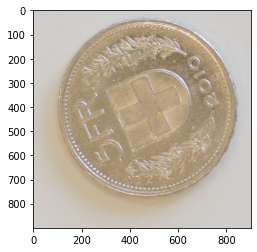

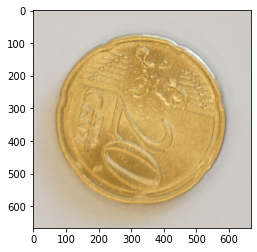

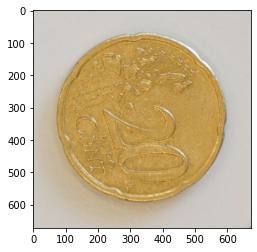

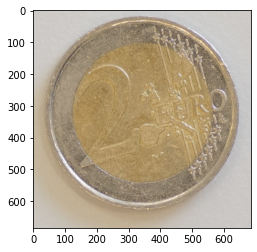

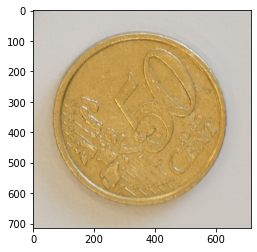

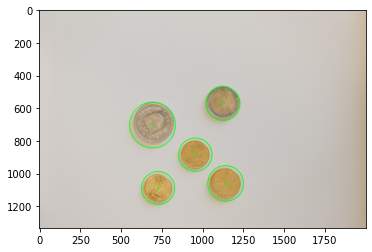

In [11]:
# d = "./data/train/1. neutral_bg//"
# d = "./data/train/2. noisy_bg///"
# d = "./data/train/3. hand///"
d = "./data/train/5. noisy_bg_outliers/"
# d = "./data/train/6. hand_outliers///"
# d = "./data/test//"
# for f in os.listdir(d):

paths = get_training_data_paths()
p = paths[0]
if get_label_for_image(p).shape[0] == 0:
    print("wrong filename")

circles = find_circles(paths[0], debug=True)
# for path in get_training_data_paths():
# img = cv.imread(f"{d}/{f}")[::3, ::3].astype(np.uint8)
# img[:, :, 1] = 0



In [12]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [13]:
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
resnet152 = torchvision.models.resnet152(weights=torchvision.models.ResNet152_Weights.IMAGENET1K_V2).to(device)
def extract_features(input_image):
    # or any of these variants
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
    resnet152.eval()
    feature_extractor = torch.nn.Sequential(*list(resnet152.children())[:-1])

    image_dim = torch.tensor([input_image.shape[0]]).to(device)
    # print(image_dim)

    input_image = Image.fromarray(input_image)
    # input_image.show()
    preprocess = transforms.Compose([
        # transforms.Resize(256),
        transforms.CenterCrop(850),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    
    # plt.imshow(input_tensor.permute(1, 2, 0))
    # plt.show()
    
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available

    input_batch = input_batch.to(device)
    feature_extractor.to(device)

    with torch.no_grad():
        features = feature_extractor(input_batch)
    # Tensor of shape 1000, with confidence scores over ImageNet's 1000 classes
    # print(output[0])
    # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
    # probabilities = torch.nn.functional.softmax(output[0], dim=0)
    features = torch.flatten(features)
    # features = torch.cat((features, image_dim))

    # print(features.size())
    return features




In [14]:
for circle in circles:
    print(extract_features(circle).shape)

torch.Size([2048])
torch.Size([2048])
torch.Size([2048])
torch.Size([2048])
torch.Size([2048])


In [15]:
def get_test_data_paths():
    test_paths = []
    base_dir = "./data/test/"
    for path in os.listdir(base_dir):
        file_path = f"{base_dir}/{path}"
        test_paths.append(file_path)
            # print(file_path)
    return test_paths



## Training on individual coin

In [16]:
class_names = ["chf_5", "chf_2", "chf_1", "chf_0.5", "chf_0.2", "chf_0.1", "chf_0.05", "eur_2", "eur_1", "eur_0.5", "eur_0.2", "eur_0.1", "eur_0.05", "eur_0.02", "eur_0.01", "OOD", "bg"]


In [17]:
def get_training_set_size():
    size = 0
    for index, c in enumerate(class_names):
        labeled_coins_dir = "./data/labeled_coins/"
        selected_dir = f"{labeled_coins_dir}{c}"
        files = os.listdir(selected_dir)
        size += len(files)
    return size

print(get_training_set_size())

578


### background classifier

In [18]:

data_set_size = get_training_set_size()

trainX_bg = torch.zeros((data_set_size, 2048)).to(device)
trainY_bg = torch.zeros(data_set_size).to(device)

data_index = 0

for index, c in enumerate(class_names):
    print(f"extracting class {index}")
    labeled_coins_dir = "./data/labeled_coins/"
    selected_dir = f"{labeled_coins_dir}{c}"
    files = os.listdir(selected_dir)
    for j, file in enumerate(files):
        selected_file_path = f"{selected_dir}/{file}"
        coin = Image.open(selected_file_path)
        # degrees = random.randint(0, 360)
        # coin = coin.rotate(degrees, resample=Image.BICUBIC)
    #     # coin.show()
        
    #     """
    #     extracting features + training
    #     """

    #     optimizer.zero_grad()
        x = extract_features(np.array(coin))
        trainX_bg[data_index] = x
        val_y = 0
        if (index == class_names.index("bg")):
            val_y = 1
        trainY_bg[data_index] = val_y

        
        data_index += 1


extracting class 0
extracting class 1
extracting class 2
extracting class 3
extracting class 4
extracting class 5
extracting class 6
extracting class 7
extracting class 8
extracting class 9
extracting class 10
extracting class 11
extracting class 12
extracting class 13
extracting class 14
extracting class 15
extracting class 16


In [19]:
bg_classifier = torch.nn.Sequential( 
    torch.nn.Linear(in_features = 2048, out_features = 512), 
    torch.nn.ReLU(),
    torch.nn.Linear(in_features = 512, out_features = 1), 
    torch.nn.Sigmoid()
)

bg_classifier = bg_classifier.to(device)

In [20]:
criterion_bg = torch.nn.BCELoss()
optimizer_bg = torch.optim.Adam(bg_classifier.parameters(), lr=5e-4)


trainY_bg = trainY_bg.unsqueeze(0).view(-1, 1)
# print(trainY_ood)


nb_epochs = 1200

for epoch in range(nb_epochs):
    optimizer_bg.zero_grad()
            
    pred_bg = bg_classifier(trainX_bg)
    # print(pred_ood)
    # print(pred.shape)
    loss_bg = criterion_bg(pred_bg, trainY_bg.to(device)) 
    loss_bg.backward() 
    # print(f"loss at epoch {epoch} - {loss}")
    if epoch %50 == 0:
        print(f"loss at {epoch} - {loss_bg}")
    optimizer_bg.step() 
        

loss at 0 - 0.6933926343917847
loss at 50 - 0.02915666624903679
loss at 100 - 0.01027027890086174
loss at 150 - 0.004716506227850914
loss at 200 - 0.002629885682836175
loss at 250 - 0.0016713507939130068
loss at 300 - 0.0011565358145162463
loss at 350 - 0.0008485704893246293
loss at 400 - 0.0006495943525806069
loss at 450 - 0.0005134862149134278
loss at 500 - 0.00041620343108661473
loss at 550 - 0.0003442034940235317
loss at 600 - 0.0002893930359277874
loss at 650 - 0.00024667548132129014
loss at 700 - 0.00021272602316457778
loss at 750 - 0.0001852877321653068
loss at 800 - 0.00016278642578981817
loss at 850 - 0.0001440997002646327
loss at 900 - 0.0001284078462049365
loss at 950 - 0.00011510054173413664
loss at 1000 - 0.00010371794633101672
loss at 1050 - 9.390625928062946e-05
loss at 1100 - 8.538737165508792e-05
loss at 1150 - 7.794057455612347e-05


### training ood classifier

In [21]:
data_set_size = get_training_set_size()

trainX_ood = torch.zeros((data_set_size, 2048)).to(device)
trainY_ood = torch.zeros(data_set_size).to(device)

data_index = 0

for index, c in enumerate(class_names):
    print(f"extracting class {index}")
    labeled_coins_dir = "./data/labeled_coins/"
    selected_dir = f"{labeled_coins_dir}{c}"
    files = os.listdir(selected_dir)
    for j, file in enumerate(files):
        selected_file_path = f"{selected_dir}/{file}"
        coin = Image.open(selected_file_path)
        # degrees = random.randint(0, 360)
        # coin = coin.rotate(degrees, resample=Image.BICUBIC)
    #     # coin.show()
        
    #     """
    #     extracting features + training
    #     """

    #     optimizer.zero_grad()
        x = extract_features(np.array(coin))
        trainX_ood[data_index] = x
        val_y = 0
        if (index == class_names.index("OOD")):
            val_y = 1
        trainY_ood[data_index] = val_y

        
        data_index += 1




 


extracting class 0
extracting class 1
extracting class 2
extracting class 3
extracting class 4
extracting class 5
extracting class 6
extracting class 7
extracting class 8
extracting class 9
extracting class 10
extracting class 11
extracting class 12
extracting class 13
extracting class 14
extracting class 15
extracting class 16


#### svm test

In [25]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Split your data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(trainX_ood.cpu(), trainY_ood.cpu(), test_size=0.2, random_state=42)

# Initialize the SVM classifier with desired parameters
clf = svm.SVC(kernel='linear', C=1.0)  # You can choose other kernels like 'rbf', 'poly', etc.

# Train the classifier
clf.fit(X_train, y_train)

# Predict the labels for the validation set
y_pred = clf.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Generate a classification report
print(classification_report(y_val, y_pred))

# Display the confusion matrix
print(confusion_matrix(y_val, y_pred))


Accuracy: 1.00
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       111
         1.0       1.00      1.00      1.00         5

    accuracy                           1.00       116
   macro avg       1.00      1.00      1.00       116
weighted avg       1.00      1.00      1.00       116

[[111   0]
 [  0   5]]


In [ ]:
ood_classifier = torch.nn.Sequential( 
    torch.nn.Linear(in_features = 2048, out_features = 512), 
    torch.nn.ReLU(),
    torch.nn.Linear(in_features = 512, out_features = 1), 
    torch.nn.Sigmoid()
)

ood_classifier = ood_classifier.to(device)

In [ ]:
criterion_ood = torch.nn.BCELoss()
optimizer_ood = torch.optim.Adam(ood_classifier.parameters(), lr=5e-4)


trainY_ood = trainY_ood.unsqueeze(0).view(-1, 1)
# print(trainY_ood)


nb_epochs = 2000

for epoch in range(nb_epochs):
    optimizer_ood.zero_grad()
            
    pred_ood = ood_classifier(trainX_ood)
    # print(pred_ood)
    # print(pred.shape)
    loss_ood = criterion_ood(pred_ood, trainY_ood.to(device)) 
    loss_ood.backward() 
    # print(f"loss at epoch {epoch} - {loss}")
    if epoch %50 == 0:
        print(f"loss at {epoch} - {loss_ood}")
    optimizer_ood.step() 
        
            

### training chf/eur classifier

In [ ]:
labeled_coins_dir = "./data/labeled_coins/"
data_set_size = get_training_set_size() - len(os.listdir(labeled_coins_dir+"bg")) - len(os.listdir(labeled_coins_dir+"OOD"))

trainX = torch.zeros((data_set_size, 2048)).to(device)
trainY = torch.zeros(data_set_size).to(device)

data_index = 0


for index, c in enumerate(class_names):
    if index >= len(class_names) - 2: continue

    print(f"extracting class {index}")
    selected_dir = f"{labeled_coins_dir}{c}"
    files = os.listdir(selected_dir)
    for j, file in enumerate(files):
        target = torch.tensor([index]).to(device)

        selected_file_path = f"{selected_dir}/{file}"
        coin = Image.open(selected_file_path)
        # degrees = random.randint(0, 360)
        # coin = coin.rotate(degrees, resample=Image.BICUBIC)
    #     # coin.show()
        
    #     """
    #     extracting features + training
    #     """

    #     optimizer.zero_grad()
        x = extract_features(np.array(coin))
        trainX[data_index] = x
        trainY[data_index] = index

        
        data_index += 1

In [ ]:
linear = torch.nn.Sequential( 
    torch.nn.Linear(in_features = 2048, out_features = 512), 
    torch.nn.ReLU(),
    torch.nn.Linear(in_features = 512, out_features = 15), 

)

linear = linear.to(device)


In [ ]:

criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(linear.parameters(), lr=5e-4)

nb_epochs = 1750

for epoch in range(nb_epochs):
    optimizer.zero_grad()
            
    pred = linear(trainX)
    # print(pred.shape)
    loss = criterion(pred, trainY.to(device).long()) 
    loss.backward() 
    # print(f"loss at epoch {epoch} - {loss}")
    if epoch %50 == 0:
        print(f"loss at {epoch} - {loss}")
    optimizer.step() 
  


In [ ]:
print(trainY.shape)
print(trainY)


In [ ]:
csv_header = "id,5CHF,2CHF,1CHF,0.5CHF,0.2CHF,0.1CHF,0.05CHF,2EUR,1EUR,0.5EUR,0.2EUR,0.1EUR,0.05EUR,0.02EUR,0.01EUR,OOD"



In [ ]:
def path_to_filename(path):
    return path.split("/")[-1].split(".")[0]

## Testing

### filter functions

In [ ]:
def find_radius(coin, min_radius, max_radius, debug=False):
    img = (rgb2gray(coin)*255).astype(np.uint8)
    down = 2
    img = cv.blur(img, (16, 16))[::down, ::down]
    
    min_r = int((min_radius*0.9)//down)
    max_r = int((max_radius*1.5)//down)
    
    circle = cv.HoughCircles(img, cv.HOUGH_GRADIENT_ALT, dp=1, minDist = 50, minRadius=min_r, maxRadius=max_r, param1=50, param2=0.8)
    # print(circle)
    
    if circle is not None:
# convert the (x, y) coordinates and radius of the circles to integers
        circles = np.round(circle[0, :]).astype("int")
        circles = filter_circles(circles)
        # print(f"detected {len(circles)} circles")
    
        for (x, y, r) in circles:
            # print(x, y, r)
            # draw the circle in the output image, then draw a rectangle
                # corresponding to the center of the circle
            radius = down*r
            if debug:
                # print()
                cv.circle(coin, (down*x, down*y), down*r, (0, 255, 0), 4)
                plt.title(f"radius: {radius}")
                plt.imshow(coin)
                plt.show()
            return radius
    else:
        if debug:
            print("no circle found")
        return 0
            # new_circle = extract_circles_images(x, y, r, full_size_img, down)
               

In [ ]:
def find_radius_eur_cents(coin, min_radius, max_radius, debug=False):
    img = (rgb2gray(coin)*255).astype(np.uint8)
    img = cv.blur(img, (16, 16))[::3, ::3]
    
    min_r = int((min_radius*0.9)//3)
    max_r = int((max_radius*1.1)//3)
    
    circle = cv.HoughCircles(img, cv.HOUGH_GRADIENT_ALT, dp=1, minDist = 50, minRadius=min_r, maxRadius=max_r, param1=50, param2=0.6)
    # print(circle)
    
    if circle is not None:
# convert the (x, y) coordinates and radius of the circles to integers
        circles = np.round(circle[0, :]).astype("int")
        circles = filter_circles(circles)
        # print(f"detected {len(circles)} circles")
    
        for (x, y, r) in circles:
            # print(x, y, r)
            # draw the circle in the output image, then draw a rectangle
                # corresponding to the center of the circle
            radius = 3*r
            if debug:
                # print()
                cv.circle(coin, (3*x, 3*y), 3*r, (0, 255, 0), 4)
                plt.title(f"radius: {radius}")
                plt.imshow(coin)
                plt.show()
            return radius
    else:
        if debug:
            print("no circle found")
        return 0
            # new_circle = extract_circles_images(x, y, r, full_size_img, down)
               

In [ ]:
def test_chf_cents(coin, pred_class, debug=False):
    previous_class = pred_class
    cents_20_radius = 240
    cents_10_radius = 228
    cents_50_radius = 208
    
    radius = find_radius(coin, min_radius=cents_50_radius, max_radius=cents_10_radius, debug=debug)
    if radius < 150: return pred_class
        
    values = np.array((cents_50_radius, cents_20_radius, cents_10_radius))
    classes = [3, 4, 5]
    pred = classes[np.argmin(np.abs(values - radius))]
    if debug:
        print(f"returning {class_names[pred]}, before {class_names[previous_class]}")
    return pred

In [ ]:
def test_chf_francs(coin, pred_class, debug=False):
    francs_2_radius = 315
    francs_1_radius = 265
    
    radius = find_radius(coin, min_radius=francs_1_radius, max_radius=francs_2_radius, debug=debug)
    if radius < 240: return pred_class
        
    values = np.array((francs_2_radius, francs_1_radius))
    classes = [1, 2]
    pred = classes[np.argmin(np.abs(values - radius))]
    if debug:
        print(f"returning {class_names[pred]} - before {class_names[pred_class]}")
    return pred

In [ ]:
def test_eur_cents(coin, pred_class, debug=False):
    cents_1_radius = 192
    cents_2_radius = 222
    cents_5_radius = 249
    
    radius = find_radius_eur_cents(coin, min_radius=cents_1_radius, max_radius=cents_5_radius, debug=debug)
    if radius < 170: return pred_class
        
    values = np.array((cents_5_radius, cents_2_radius, cents_1_radius))
    classes = [12, 13, 14]
    pred = classes[np.argmin(np.abs(values - radius))]
    if debug:
        print(f"returning {class_names[pred]} - before {class_names[pred_class]}")
    return pred

    

In [ ]:
def test_eur_1_2(coin, pred_class, debug=False):
    eur_2_radius = 292
    eur_1_radius = 266
    
    
    
    radius = find_radius(coin, min_radius=eur_1_radius, max_radius=eur_2_radius, debug=debug)
    if radius < 240: return pred_class
        
    values = np.array((eur_2_radius, eur_1_radius))
    classes = [7, 8]
    pred = classes[np.argmin(np.abs(values - radius))]
    if debug:
        print(f"returning {class_names[pred]} - before {class_names[pred_class]}")
    return pred


### evaluation

In [ ]:
index = np.random.randint(0, 17)
csv_file = csv_header
csv_file += "\n"
with torch.no_grad():
# index = 16
    linear.eval()
    ood_classifier.eval()
    bg_classifier.eval()

    # labeled_coins_dir = "./data/labeled_coins/"
    # selected_dir = f"{labeled_coins_dir}{class_names[index]}"
    # files = os.listdir(selected_dir)
    # selected_file = random.choice(files)
    # selected_file_path = f"{selected_dir}/{selected_file}"
    # print(selected_file_path)

    for i, path in enumerate(get_test_data_paths()):
        print(path)
    
        # path = "./data/test/L0000113.JPG"
        coins = find_circles(path)
        # coins = find_circles("./data/train/1. neutral_bg/L1010277.JPG")
        
        p = np.zeros(16, dtype=np.uint8)
        for coin in coins:
            shape = coin.shape
            if shape[0] <10 or shape[1]<10: continue
            # print(coin.shape)
        
            
            
            # coin = np.array(im.open(selected_file_path))
            # coin.show()


            x = extract_features(coin).to(device)
            # print(x)
            x = torch.unsqueeze(x, 0)

            bg_pred = bg_classifier(x)
            bg_class_pred = torch.round(bg_pred).item()
            if bg_class_pred == 1: continue



            ood_pred = ood_classifier(x)
            ood_class_pred = torch.round(ood_pred).item()
            if ood_class_pred == 1:
                p[15] += 1
                # plt.imshow(coin)
                # plt.show()
                continue
            

            pred_test = linear(x).flatten()
            pred_class = torch.argmax(pred_test)
            
           
            
            
            # proba = (torch.softmax(pred_test, dim=0)*100)
            # max_proba = torch.max(proba).item()
            # print(f"{max_proba} - {class_names[pred_class]}")
            # if pred_class == 9:
            #     plt.title(class_names[pred_class.item()])
            #     plt.imshow(coin)
            #     plt.show()
            
            # if max_proba < 0.7:
            
            if pred_class==3 or pred_class == 4 or pred_class == 5:
                # print("checking chf cents")
                pred_class = test_chf_cents(coin, pred_class.item())

            # if pred_class == 6 or pred_class == 0:
            #     plt.title(class_names[pred_class])
            #     plt.imshow(coin)
            #     plt.show()
            if pred_class == 12 or pred_class == 13 or pred_class == 14:
                # print("checking eur cents")
                
                pred_class = test_eur_cents(coin, pred_class.item())
                
            elif pred_class == 7 or pred_class == 8:
                # print("checking eur cents")
                
                pred_class = test_eur_1_2(coin, pred_class.item())

            
            elif pred_class == 1 or pred_class == 2:
                # print("checking chf francs")  
                pred_class = test_chf_francs(coin, pred_class.item())
            
            # if pred_class == 4 or pred_class==5:
            #     radius = find_radius(coin)
            #     print(f"radius: {radius}")
            #     if radius != 0:
            #         if radius < 235:
            #             pred_class = 4
            #         elif radius < 220:
            #             pred_class = 6
            #         else: pred_calss = 5
                
            # print(pred_class)
            
            p[pred_class] += 1
        # print(f"pred {pred_class}")
        # print(f"target: {index}")
        
        # print(p)
        p_string = np.array2string(p, separator=', ', precision=0).replace("[", "").replace("]", "")
        csv_row = f"{path_to_filename(path)},{p_string}"
        # print(csv_row)
        print(csv_row)
        csv_file += csv_row
        csv_file += "\n"

with open('./data/submission.csv', 'w') as file:
    # Write a string to the file
    file.write(csv_file)
    
# print(csv_row)


In [ ]:
file.close()

## extracting all coins

In [ ]:
from PIL import Image as im 
paths = get_training_data_paths()
print(len(paths))

# for path in paths:
for path in paths:
    circles =find_circles(path)
    for i, circle in enumerate(circles):
        file_number = path.split("/")[-1].split(".")[0]
        print(file_number)
        im.fromarray(circle).save(f"./data/unlabeled_coins/{file_number}_{i}.jpg")
    


### label hd coins

In [ ]:
target_dir = "./data/hd_coins/"
source_dir = "./data/labeled_coins/"
unlabeled_dir = "./data/unlabeled_coins/"
for d in os.listdir(source_dir):
    class_dir = target_dir + d
    if not os.path.exists(class_dir):
        os.mkdir(class_dir)
    
    for file in os.listdir(source_dir+d):
        src_file = unlabeled_dir+file
        dst_file = target_dir + d+"/"+file
        os.rename(src_file, dst_file)
        # print(dst_file)

In [ ]:
file1 = open('./data/submission.csv', 'r')
lines = file1.readlines()
file2 = open('./data/submission_ood_bg_classifier_tests_only_coins_confirmation.csv', 'r')
lines2 = file2.readlines()

diff = 0
for i in range(len(lines2)):
    if lines[i] != lines2[i]:
        diff+=1
        print(lines[i], lines2[i])
print(diff)
